In [1]:
import numpy as np
import cv2
import matplotlib
from matplotlib import pyplot as plt
%matplotlib inline

## 1) Preprocessing: Detect face and eyes

In [ ]:
When we look at any image, most of the time we identify a person using a face. An image might contain multiple faces, also the face can be obstructed and not clear. The first step in our pre-processing pipeline is to detect faces from an image. Once face is detected, we will detect eyes, if two eyes are detected then only we keep that image otherwise discard it.


In [2]:
img = cv2.imread('./test_images/sharapova1.jpg')
img.shape

(555, 700, 3)

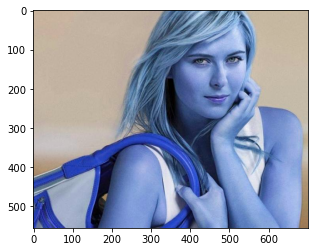

In [3]:
plt.imshow(img)

In [4]:
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
gray.shape


(555, 700)

In [5]:
gray

array([[175, 175, 175, ..., 176, 175, 174],
       [175, 175, 175, ..., 177, 175, 174],
       [175, 175, 175, ..., 177, 176, 174],
       ...,
       [ 84,  87,  88, ..., 113, 113, 113],
       [ 88,  89,  90, ..., 113, 113, 113],
       [ 93,  91,  91, ..., 112, 112, 112]], dtype=uint8)

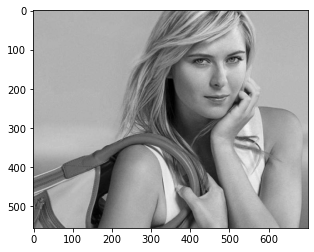

In [6]:
plt.imshow(gray , cmap = 'gray')

In [7]:
face_cascade = cv2.CascadeClassifier('./opencv/haarcascades/haarcascade_frontalface_default.xml')
eye_cascade = cv2.CascadeClassifier('./opencv/haarcascades/haarcascade_eye.xml')

faces = face_cascade.detectMultiScale(gray, 1.3, 5)
faces

array([[352,  38, 233, 233]], dtype=int32)

In [8]:
(x,y,w,h) = faces[0]   #x , y , height and width are the array dimensions
x,y,w,h


(352, 38, 233, 233)

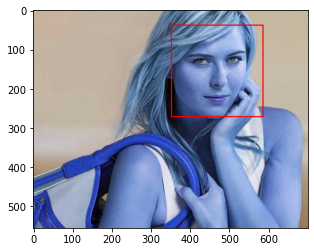

In [9]:
face_img = cv2.rectangle(img,(x,y),(x+w,y+h),(255,0,0),2) # imd is the original image and gives an 255(red) olour rectangle
plt.imshow(face_img)

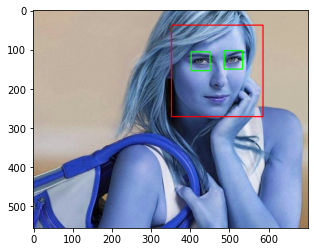

In [10]:
cv2.destroyAllWindows()
for (x,y,w,h) in faces:
    face_img = cv2.rectangle(img,(x,y),(x+w,y+h),(255,0,0),2)
    roi_gray = gray[y:y+h, x:x+w]
    roi_color = face_img[y:y+h, x:x+w]
    eyes = eye_cascade.detectMultiScale(roi_gray)
    for (ex,ey,ew,eh) in eyes:
        cv2.rectangle(roi_color,(ex,ey),(ex+ew,ey+eh),(0,255,0),2)
        

plt.figure()
plt.imshow(face_img, cmap='gray')
plt.show()


## 2) Preprocessing: Crop the facial region of the image

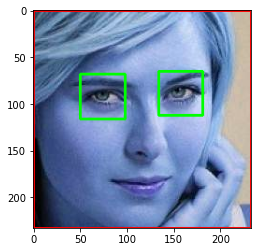

In [11]:
%matplotlib inline
plt.imshow(roi_color, cmap='gray') #the region of the rectangle ==> roi(region of intrest) will be showing 

In [12]:
cropped_img = np.array(roi_color)
cropped_img.shape


(233, 233, 3)

### (3) Preprocessing: Load image, detect face. If eyes >=2, then save and crop the face region
Lets write a python function that can take input image and returns cropped image (if face and eyes >=2 are detected)

In [13]:
def get_cropped_image_if_2_eyes(image_path):
    img = cv2.imread(image_path)
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    faces = face_cascade.detectMultiScale(gray, 1.3, 5)
    for (x,y,w,h) in faces:
        roi_gray = gray[y:y+h, x:x+w]
        roi_color = img[y:y+h, x:x+w]
        eyes = eye_cascade.detectMultiScale(roi_gray)
        if len(eyes) >= 2:
            return roi_color
    return None

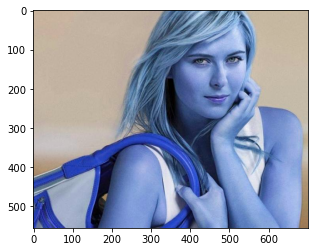

In [14]:
original_image = cv2.imread('./test_images/sharapova1.jpg')
plt.imshow(original_image)


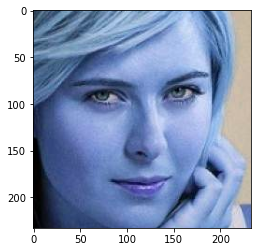

In [15]:
cropped_image = get_cropped_image_if_2_eyes('./test_images/sharapova1.jpg')
plt.imshow(cropped_image)

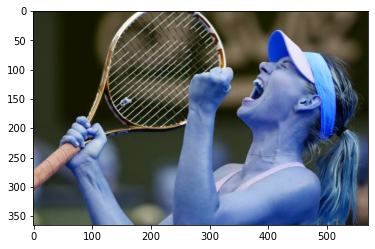

In [16]:
org_image_obstructed = cv2.imread('./test_images/sharapova2.JPG')
plt.imshow(org_image_obstructed)

In [17]:
cropped_image_no_2_eyes = get_cropped_image_if_2_eyes('./test_images/sharapova2.JPG')
cropped_image_no_2_eyes

In [18]:
path_to_data = "./dataset/"
path_to_cr_data = "./dataset/cropped/"

In [19]:
import os
img_dirs = []
for entry in os.scandir(path_to_data):
    if entry.is_dir():
        img_dirs.append(entry.path)

In [20]:
img_dirs

['./dataset/roger_federer',
 './dataset/maria_sharapova',
 './dataset/virat_kohli',
 './dataset/lionel_messi',
 './dataset/serena_williams']

**Go through all images in dataset folder and create cropped images for them. There will be cropped folder inside dataset folder after you run this code**

In [21]:
import shutil
if os.path.exists(path_to_cr_data):
     shutil.rmtree(path_to_cr_data)
os.mkdir(path_to_cr_data)

In [22]:
cropped_image_dirs = []
celebrity_file_names_dict = {}

for img_dir in img_dirs:
    count = 1
    celebrity_name = img_dir.split('/')[-1]
    print(celebrity_name)
    
    celebrity_file_names_dict[celebrity_name] = []
    
    for entry in os.scandir(img_dir):
        roi_color = get_cropped_image_if_2_eyes(entry.path)
        if roi_color is not None:
            cropped_folder = path_to_cr_data + celebrity_name
            if not os.path.exists(cropped_folder):
                os.makedirs(cropped_folder)
                cropped_image_dirs.append(cropped_folder)
                print("Generating cropped images in folder: ",cropped_folder)
            cropped_file_name = celebrity_name + str(count) + ".png"
            cropped_file_path = cropped_folder + "/" + cropped_file_name
            cv2.imwrite(cropped_file_path, roi_color)
            celebrity_file_names_dict[celebrity_name].append(cropped_file_path)
            count += 1

roger_federer
Generating cropped images in folder:  ./dataset/cropped/roger_federer
maria_sharapova
Generating cropped images in folder:  ./dataset/cropped/maria_sharapova
virat_kohli
Generating cropped images in folder:  ./dataset/cropped/virat_kohli
lionel_messi
Generating cropped images in folder:  ./dataset/cropped/lionel_messi
serena_williams
Generating cropped images in folder:  ./dataset/cropped/serena_williams


## 3) Preprocessing: Use wavelet transform as a feature for traning our model

In wavelet transformed image, you can see edges clearly and that can give us clues on various facial features such as eyes, nose, lips etc
#### Wavelet transform

In [23]:
import numpy as np
import pywt
import cv2    

def w2d(img, mode='haar', level=1):
    imArray = img
    #Datatype conversions
    #convert to grayscale
    imArray = cv2.cvtColor( imArray,cv2.COLOR_RGB2GRAY )
    #convert to float
    imArray =  np.float32(imArray)   
    imArray /= 255;
    # compute coefficients 
    coeffs=pywt.wavedec2(imArray, mode, level=level)

    #Process Coefficients
    coeffs_H=list(coeffs)  
    coeffs_H[0] *= 0;  

    # reconstruction
    imArray_H=pywt.waverec2(coeffs_H, mode);
    imArray_H *= 255;
    imArray_H =  np.uint8(imArray_H)

    return imArray_H

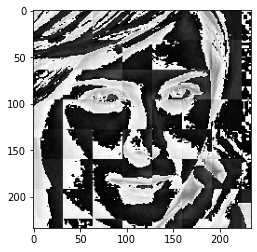

In [24]:
im_har = w2d(cropped_image, 'db1' , 5)
plt.imshow(im_har , cmap='gray')

In [25]:
celebrity_file_names_dict

{'roger_federer': ['./dataset/cropped/roger_federer/roger_federer1.png',
  './dataset/cropped/roger_federer/roger_federer2.png',
  './dataset/cropped/roger_federer/roger_federer3.png',
  './dataset/cropped/roger_federer/roger_federer4.png',
  './dataset/cropped/roger_federer/roger_federer5.png',
  './dataset/cropped/roger_federer/roger_federer6.png',
  './dataset/cropped/roger_federer/roger_federer7.png',
  './dataset/cropped/roger_federer/roger_federer8.png',
  './dataset/cropped/roger_federer/roger_federer9.png',
  './dataset/cropped/roger_federer/roger_federer10.png',
  './dataset/cropped/roger_federer/roger_federer11.png',
  './dataset/cropped/roger_federer/roger_federer12.png',
  './dataset/cropped/roger_federer/roger_federer13.png',
  './dataset/cropped/roger_federer/roger_federer14.png',
  './dataset/cropped/roger_federer/roger_federer15.png',
  './dataset/cropped/roger_federer/roger_federer16.png'],
 'maria_sharapova': ['./dataset/cropped/maria_sharapova/maria_sharapova1.png',


In [26]:
class_dict = {}
count = 0
for celebrity_name in celebrity_file_names_dict.keys():
    class_dict[celebrity_name] = count
    count = count + 1
class_dict


{'roger_federer': 0,
 'maria_sharapova': 1,
 'virat_kohli': 2,
 'lionel_messi': 3,
 'serena_williams': 4}

In [27]:
X, y = [], []
for celebrity_name, training_files in celebrity_file_names_dict.items():
    for training_image in training_files:
        img = cv2.imread(training_image)
        scalled_raw_img = cv2.resize(img, (32, 32))
        img_har = w2d(img,'db1',5)
        scalled_img_har = cv2.resize(img_har, (32, 32))
        combined_img = np.vstack((scalled_raw_img.reshape(32*32*3,1),scalled_img_har.reshape(32*32,1)))
        X.append(combined_img)
        y.append(class_dict[celebrity_name]) 

In [28]:
len(X)

152

In [29]:
X[0]

array([[ 37],
       [ 39],
       [ 87],
       ...,
       [198],
       [203],
       [194]], dtype=uint8)

In [30]:
X= np.array(X).reshape(len(X) , 4096).astype(float)
X.shape

(152, 4096)

In [31]:
X[0]

array([ 37.,  39.,  87., ..., 198., 203., 194.])

In [32]:
y[0]

0

**Data cleaning process is done.Now we are ready to train our model**

In [41]:
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report

In [42]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0)

pipe = Pipeline([('scaler', StandardScaler()), ('svc', SVC(kernel = 'rbf', C = 10))])
pipe.fit(X_train, y_train)
pipe.score(X_test, y_test)


0.7105263157894737

In [43]:
len(X_test)

38

In [44]:
print(classification_report(y_test, pipe.predict(X_test)))

              precision    recall  f1-score   support

           0       0.00      0.00      0.00         2
           1       1.00      0.88      0.93         8
           2       0.56      1.00      0.71        10
           3       0.86      0.55      0.67        11
           4       0.80      0.57      0.67         7

    accuracy                           0.71        38
   macro avg       0.64      0.60      0.60        38
weighted avg       0.75      0.71      0.70        38



**Let's use GridSearch to try out different models with different paramets. Goal is to come up with best modle with best fine tuned parameters**

In [45]:
from sklearn import svm
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import GridSearchCV


In [46]:
model_params = {
    'svm': {
        'model': svm.SVC(gamma='auto',probability=True),
        'params' : {
            'svc__C': [1,10,100,1000],
            'svc__kernel': ['rbf','linear']
        }  
    },
    'random_forest': {
        'model': RandomForestClassifier(),
        'params' : {
            'randomforestclassifier__n_estimators': [1,5,10]
        }
    },
    'logistic_regression' : {
        'model': LogisticRegression(solver='liblinear',multi_class='auto'),
        'params': {
            'logisticregression__C': [1,5,10]
        }
    }
}


In [47]:
scores = []
best_estimators = {}
import pandas as pd
for algo, mp in model_params.items():
    pipe = make_pipeline(StandardScaler(), mp['model'])
    clf =  GridSearchCV(pipe, mp['params'], cv=5, return_train_score=False)
    clf.fit(X_train, y_train)
    scores.append({
        'model': algo,
        'best_score': clf.best_score_,
        'best_params': clf.best_params_
    })
    best_estimators[algo] = clf.best_estimator_
    
df = pd.DataFrame(scores,columns=['model','best_score','best_params'])
df

model  best_score  \
0                  svm    0.727668   
1        random_forest    0.649802   
2  logistic_regression    0.824111   

                                   best_params  
0       {'svc__C': 1, 'svc__kernel': 'linear'}  
1  {'randomforestclassifier__n_estimators': 5}  
2                 {'logisticregression__C': 1}

In [48]:
best_estimators

{'svm': Pipeline(steps=[('standardscaler', StandardScaler()),
                 ('svc',
                  SVC(C=1, gamma='auto', kernel='linear', probability=True))]),
 'random_forest': Pipeline(steps=[('standardscaler', StandardScaler()),
                 ('randomforestclassifier',
                  RandomForestClassifier(n_estimators=5))]),
 'logistic_regression': Pipeline(steps=[('standardscaler', StandardScaler()),
                 ('logisticregression',
                  LogisticRegression(C=1, solver='liblinear'))])}

In [49]:
best_estimators['svm'].score(X_test,y_test)

0.7894736842105263

In [50]:
best_estimators['random_forest'].score(X_test,y_test)

0.5263157894736842

In [51]:
best_estimators['logistic_regression'].score(X_test,y_test)


0.8421052631578947

In [53]:
best_clf = best_estimators['logistic_regression']

In [54]:
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_test, best_clf.predict(X_test))
cm

array([[2, 0, 0, 0, 0],
       [0, 8, 0, 0, 0],
       [0, 0, 9, 0, 1],
       [1, 0, 0, 8, 2],
       [1, 1, 0, 0, 5]])

Text(69.0, 0.5, 'Truth')

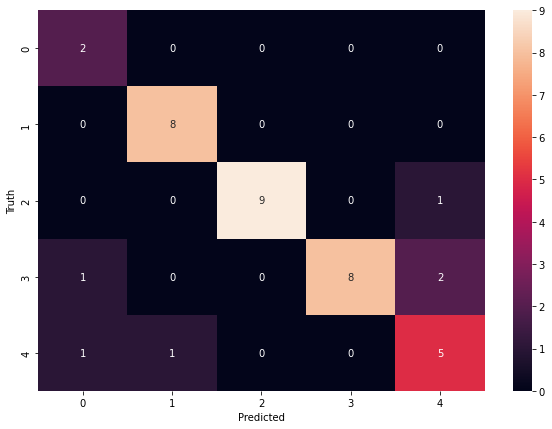

In [55]:
import seaborn as sn
plt.figure(figsize = (10,7))
sn.heatmap(cm, annot=True)
plt.xlabel('Predicted')
plt.ylabel('Truth')

In [56]:
class_dict


{'roger_federer': 0,
 'maria_sharapova': 1,
 'virat_kohli': 2,
 'lionel_messi': 3,
 'serena_williams': 4}

**Save the trained model**

In [57]:
!pip install joblib
import joblib 
# Save the model as a pickle in a file 
joblib.dump(best_clf, 'saved_model.pkl') 


['saved_model.pkl']

**Save class dictionary**

In [58]:
import json
with open("class_dictionary.json","w") as f:
    f.write(json.dumps(class_dict))

SyntaxError: invalid syntax (759945234.py, line 1)